In [41]:
import pandas as pd
from sklearn.decomposition import PCA
from reframed import load_cbmodel

In [2]:
data1 = pd.read_csv('../datasets/transcriptomics/yang_2011/E-GEOD-27447-A-AFFY-141-normalized-expressions.tsv', sep='\t')
mdata1 = pd.read_csv('../datasets/transcriptomics/yang_2011/E-GEOD-27447-experiment-design.tsv', sep='\t', usecols=[0,2])

In [3]:
data2 = pd.read_csv('../datasets/transcriptomics/komatsu_2013/E-GEOD-38959-A-AGIL-28-normalized-expressions.tsv', sep='\t')
mdata2 = pd.read_csv('../datasets/transcriptomics/komatsu_2013/E-GEOD-38959-experiment-design.tsv', sep='\t', usecols=[0,4])

In [5]:
healthy1 = mdata1[mdata1['Sample Characteristic[clinical information]'] == 'non-triple negative breast cancer tumor']['Assay']
disease1 = mdata1[mdata1['Sample Characteristic[clinical information]'] == 'triple negative breast cancer tumor']['Assay']

In [6]:
healthy2 = mdata2[mdata2['Sample Characteristic[cell type]'] == 'mammary gland ductal cell']['Assay']
disease2 = mdata2[mdata2['Sample Characteristic[cell type]'] == 'triple negative breast cancer cell']['Assay']

## Vulcano plot

In [8]:
data = pd.merge(data1, data2, on=['Gene ID']) 

In [19]:
X = data[pd.concat([healthy1, healthy2, disease1, disease2])].T
pca = PCA(n_components=2)
Y = pca.fit_transform(X)
df = pd.DataFrame(Y, index=pd.concat([healthy1, healthy2, disease1, disease2]))

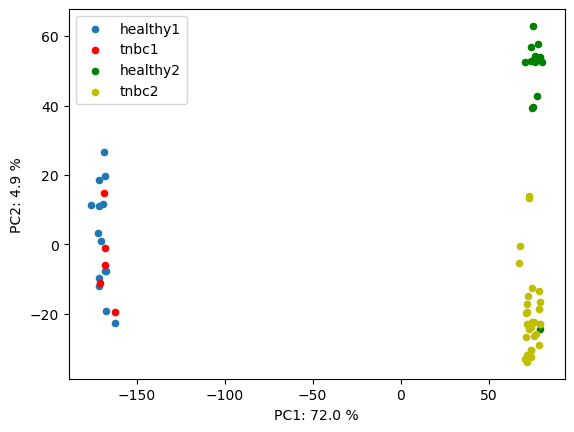

In [22]:
ax = df.loc[healthy1,:].plot.scatter(0, 1)
df.loc[disease1,:].plot.scatter(0, 1, color='r', ax=ax)
df.loc[healthy2,:].plot.scatter(0, 1, color='g', ax=ax)
df.loc[disease2,:].plot.scatter(0, 1, color='y', ax=ax)
ax.set_xlabel(f'PC1: {100*pca.explained_variance_ratio_[0]:.1f} %')
ax.set_ylabel(f'PC2: {100*pca.explained_variance_ratio_[1]:.1f} %')
ax.legend(['healthy1', 'tnbc1', 'healthy2', 'tnbc2'])

## Fold-changes

In [44]:
processed1 = pd.read_csv('../datasets/transcriptomics/yang_2011/E-GEOD-27447-A-AFFY-141-analytics.tsv', 
                         sep='\t', usecols=[0, 3, 5], header=0, names=['Gene ID', 'q', 'log2fc'])

processed2 = pd.read_csv('../datasets/transcriptomics/komatsu_2013/E-GEOD-38959-A-AGIL-28-analytics.tsv',
                         sep='\t', usecols=[0, 3, 5], header=0, names=['Gene ID', 'q', 'log2fc'])

In [45]:
df = pd.merge(processed1, processed2, on='Gene ID')

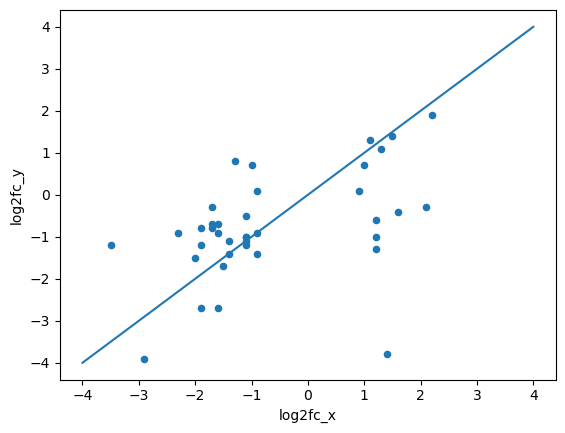

In [46]:
ax = df.dropna().query('q_x < 0.1 and q_y < 0.1').plot.scatter('log2fc_x', 'log2fc_y')
ax.plot([-4, 4], [-4, 4])

## Metabolic genes

In [42]:
recon3 = load_cbmodel('../mappings/Recon3D.xml.gz')
entrez = pd.read_csv('../mappings/Homo_sapiens.GRCh38.113.entrez.tsv', sep='\t', usecols=[0,3], header=0, dtype=str, names=['Gene ID', 'entrez'])

gpr = recon3.gene_to_reaction_lookup()
gpr = pd.DataFrame(gpr.items(), columns=['gene', 'reactions'])
gpr['entrez'] = gpr['gene'].apply(lambda x: x.split('_')[1])
gpr = pd.merge(entrez, gpr, on='entrez')

def merge_and_sort(x):
    return sorted({z for y in x for z in y})
    
gpr = gpr.groupby('Gene ID', as_index=False).agg({'reactions': merge_and_sort})

In [48]:
df = pd.merge(df, gpr, on='Gene ID')

In [50]:
df.dropna().query('q_x < 0.1 and q_y < 0.1')

,Gene ID,q_x,log2fc_x,q_y,log2fc_y,reactions
1351,ENSG00000176597,0.067583,1.5,0.000098,1.4,"[R_B3GNT51g, R_HMR_0765, R_HMR_0859]"
1367,ENSG00000178538,0.058551,-1.5,0.000075,-1.7,[R_HCO3Ee]
1497,ENSG00000197594,0.070819,-1.7,0.068729,-0.7,"[R_DNADDP, R_DPCOAPP, R_FADDP, R_FADDPle, R_UD..."


### up-regulated

In [53]:
up_rxns = merge_and_sort(df.query('log2fc_x > 1 and log2fc_y > 1 and q_x < 0.1 and q_y < 0.1')['reactions'])

for r_id in up_rxns:
    print(recon3.reactions[r_id].name)
    recon3.print_reaction(r_id, use_names=True)
    print()

UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosaminyltransferase 5
R_B3GNT51g: Galactosyl glucosyl ceramide + UDP-N-acetyl-D-glucosamine --> (Gal)1 (Glc)1 (GlcNAc)1 (Cer)1 + H+ + UDP C9H11N2O12P2

HMR 0765
R_HMR_0765: Glucocerebroside (homo sapiens) + UDPgalactose --> Galactosyl glucosyl ceramide + H+ + UDP C9H11N2O12P2

Lactosylceramide 1, 3-N-Acetyl-Beta-D-Glucosaminyltransferase
R_HMR_0859: Galactosyl glucosyl ceramide + UDP-N-acetyl-D-glucosamine --> (Gal)1 (Glc)1 (GlcNAc)1 (Cer)1 + H+ + UDP C9H11N2O12P2



### down-regulated

In [58]:
down_rxns = merge_and_sort(df.query('log2fc_x < -1 and log2fc_y < -1 and q_x < 0.1 and q_y < 0.1')['reactions'])

for r_id in down_rxns:
    print(recon3.reactions[r_id].name)
    recon3.print_reaction(r_id, use_names=True)
    print()

HCO3 equilibration reaction, extracellular
R_HCO3Ee: CO2 CO2 + H2O H2O <-> H+ + Bicarbonate

